In [89]:
import yfinance as yf

In [90]:
#constraints

budget = 2000
risk_tolerance = 0.5 # q 
penalty = 10**10 #lambda 

In [91]:
#calculating the return
def daily_returns(yesterday, today):
    if yesterday == 0:
        return 0
    return (today - yesterday) / yesterday

def expected_return(days, list_of_returns):
    return sum(list_of_returns) / days

def variance_of_asset(list_of_returns, days):
    mean_return = expected_return(days, list_of_returns)
    return sum((r - mean_return) ** 2 for r in list_of_returns) / days

def covariance(asset1_returns, asset2_returns, days):
    mean_asset1 = expected_return(days, asset1_returns)
    mean_asset2 = expected_return(days, asset2_returns)
    return sum((asset1_returns[i] - mean_asset1) * (asset2_returns[i] - mean_asset2) for i in range(days)) / days

In [92]:
import pandas as pd

tickers = ['AAPL', 'IBM', 'NFLX', 'TSLA']
data = yf.download(tickers, start="2023-01-01", end="2025-01-01")

close_prices = data['Close']

#close_prices = close_prices.pct_change().dropna()

def compute_return_and_variance(ticker, close_prices):
    list_of_returns = []
    for i in range(1, len(close_prices[ticker])):
        daily_return = daily_returns(close_prices[ticker].iloc[i-1], close_prices[ticker].iloc[i])
        list_of_returns.append(daily_return)
    average_return = expected_return(len(list_of_returns), list_of_returns)
    variance = variance_of_asset(list_of_returns, len(list_of_returns))
    print(f"Average daily return for {ticker}: {average_return:.4f}")
    print(f"Variance of daily returns for {ticker}: {variance:.4f}")
    return average_return, variance

for ticker in tickers:
    compute_return_and_variance(ticker, close_prices)




[                       0%                       ]

[*********************100%***********************]  4 of 4 completed

Average daily return for AAPL: 0.0015
Variance of daily returns for AAPL: 0.0002
Average daily return for IBM: 0.0011
Variance of daily returns for IBM: 0.0002
Average daily return for NFLX: 0.0024
Variance of daily returns for NFLX: 0.0005
Average daily return for TSLA: 0.0033
Variance of daily returns for TSLA: 0.0013


another way of calculating returns

In [93]:
returns = close_prices.pct_change().dropna()
mean_returns = returns.mean()
for ticker in tickers:
    print(f"Average daily return for {ticker}: {mean_returns[ticker]:.4f}")
cov_matrix = returns.cov()
print("\nCovariance Matrix:")   
print(cov_matrix)

Average daily return for AAPL: 0.0015
Average daily return for IBM: 0.0011
Average daily return for NFLX: 0.0024
Average daily return for TSLA: 0.0033

Covariance Matrix:
Ticker      AAPL       IBM      NFLX      TSLA
Ticker                                        
AAPL    0.000181  0.000025  0.000103  0.000186
IBM     0.000025  0.000158  0.000040  0.000007
NFLX    0.000103  0.000040  0.000454  0.000191
TSLA    0.000186  0.000007  0.000191  0.001349


In [94]:
Sigma = cov_matrix.to_numpy()

QUBO (quadratic unconstrained binary optimization)

In [95]:
import numpy as np
last_day = close_prices.iloc[-1]
asset_prices = [(ticker, last_day[ticker]) for ticker in tickers]
print("\nAsset Prices on Last Day:")
for ticker, price in asset_prices:
    print(f"{ticker}: ${price:.2f}")

#calculate n_i max for each asset:
n_i_max_list = []
for ticker, price in asset_prices:
    n_i_max = np.floor(budget / price)
    n_i_max_list.append((ticker, n_i_max))
    print(f"Maximum number of shares for {ticker} with budget ${budget}: {n_i_max}")



Asset Prices on Last Day:
AAPL: $249.82
IBM: $216.93
NFLX: $891.32
TSLA: $403.84
Maximum number of shares for AAPL with budget $2000: 8.0
Maximum number of shares for IBM with budget $2000: 9.0
Maximum number of shares for NFLX with budget $2000: 2.0
Maximum number of shares for TSLA with budget $2000: 4.0


In [96]:
d_i_list = []
for ticker, n_i_max in n_i_max_list:
    if n_i_max > 0:
        d_i = int(np.floor(np.log2(n_i_max)))
    else:
        d_i = 0
    d_i_list.append((ticker, d_i))
    print(f"Value of d_i for {ticker}: {d_i}")


Value of d_i for AAPL: 3
Value of d_i for IBM: 3
Value of d_i for NFLX: 1
Value of d_i for TSLA: 2


In [97]:
d_values = [d_i for _, d_i in d_i_list]
num_assets = len(d_values)
total_bits = sum(d+ 1 for d in d_values)
print(f"\nTotal number of bits required for all assets: {total_bits}")


Total number of bits required for all assets: 13


constructing the encoding matrix $C$

In [98]:
C = np.zeros((num_assets, total_bits))

col = 0 

for i, d in enumerate(d_values):
    for j in range(d+1):
        C[i, col] = 2 ** j
        col += 1


Calculating 
$$
P'= P/B \\
\mu' = P' \circ \mu \\
\Sigma' = (P' \circ \Sigma)^T \circ P'\\
\mu^{\prime\prime} = C^T \mu' \\
\Sigma'' = C^T \Sigma'C \\
P'' = C^T P'
$$

In [99]:
# List P of current prices of assets 
P = np.array([price for _, price in asset_prices])
P_prime = P / budget
P_double_prime = C.T @ P_prime


mu = np.array([mean_returns[ticker] for ticker in tickers])
mu_prime = P_prime * mu 

mu_prime_series = pd.Series(mu_prime, index=tickers)


print("\nScaled expected return vector µ′:")
print(mu_prime_series)




Scaled expected return vector µ′:
AAPL    0.000187
IBM     0.000122
NFLX    0.001084
TSLA    0.000666
dtype: float64


In [100]:
P_prime_sigma = P_prime * Sigma
Sigma_prime = P_prime_sigma.T * P_prime 

mu_double_prime = C.T @ mu_prime

Sigma_double_prime = C.T @ Sigma_prime @ C


Constructing the Hamiltonian

In [101]:
from qiskit.quantum_info import SparsePauliOp, Pauli

n = len(P_double_prime) #total number of binary variables
from qiskit.circuit.library import RealAmplitudes, PauliTwoDesign
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import StatevectorEstimator, Sampler
from qiskit.quantum_info import Operator
estimator = StatevectorEstimator()

optimizer = COBYLA()

The mathematical proof can be found in QUBOtoIsing.pdf that I have in this folder

In [102]:
#first hamiltonian
pi1 = 0.5 * P_double_prime
beta1 = -0.5 * np.sum(P_double_prime) + 1
h_vec = 0.5 * mu_double_prime - 0.5 * risk_tolerance * np.sum(Sigma_double_prime, axis=1)
J_mat = -0.25 * Sigma_double_prime
const_term1 = 0.5 * np.sum(mu_double_prime) - 0.25 * risk_tolerance * np.sum(Sigma_double_prime)
pauli_dict2 = {}

for i in range(n):
    label = ['I'] * n
    label[n-i-1] = 'Z'
    pauli_str = ''.join(label)
    pauli_dict2[pauli_str] = pauli_dict2.get(pauli_str, 0) + h_vec[i]

for i in range(n):
    for j in range(i , n):
        Jij = float(J_mat[i, j])
        if Jij != 0:
            if i == j:
                identity_str = 'I' * n
                pauli_dict2[identity_str] = pauli_dict2.get(identity_str, 0) + Jij
            else:
                label = ['I'] * n
                label[n-i-1] = 'Z'
                label[n-j-1] = 'Z'
                pauli_str = ''.join(label)
                pauli_dict2[pauli_str] = pauli_dict2.get(pauli_str, 0) + 2 * Jij


for i in range(n):
    label = ['I'] * n
    label[n-i-1] = 'Z'
    pauli_str = ''.join(label)
    coeff = -2 * penalty * beta1 * pi1[i]
    pauli_dict2[pauli_str] = pauli_dict2.get(pauli_str, 0) + coeff

for i in range(n):
    for j in range(i, n):
        factor = +penalty * pi1[i] * pi1[j]
        if i == j:
            identity_str = 'I' * n
            pauli_dict2[identity_str] = pauli_dict2.get(identity_str, 0) + factor
        else:
            label = ['I'] * n
            label[n-i-1] = 'Z'
            label[n-j-1] = 'Z'
            pauli_str = ''.join(label)
            pauli_dict2[pauli_str] = pauli_dict2.get(pauli_str, 0) + 2*factor

pauli_dict2['I' * n] = pauli_dict2.get('I' * n, 0) + penalty * beta1**2 + const_term1

pauli_terms2 = list(pauli_dict2.items())

print("\nPauli terms for the Hamiltonian:")
for term, coeff in pauli_terms2:
    print(f"{term}: {coeff}")



Pauli terms for the Hamiltonian:
IIIIIIIIIIIIZ: 2654957245.328179
IIIIIIIIIIIZI: 5309914490.656358
IIIIIIIIIIZII: 10619828981.312716
IIIIIIIIIZIII: 21239657962.62543
IIIIIIIIZIIII: 2305460483.4418144
IIIIIIIZIIIII: 4610920966.883629
IIIIIIZIIIIII: 9221841933.767258
IIIIIZIIIIIII: 18443683867.534515
IIIIZIIIIIIII: 9472586051.65896
IIIZIIIIIIIII: 18945172103.31792
IIZIIIIIIIIII: 4291847019.003161
IZIIIIIIIIIII: 8583694038.006322
ZIIIIIIIIIIII: 17167388076.012644
IIIIIIIIIIIII: 55616954037.25348
IIIIIIIIIIIZZ: 156021792.82866195
IIIIIIIIIIZIZ: 312043585.6573239
IIIIIIIIIZIIZ: 624087171.3146478
IIIIIIIIZIIIZ: 67741595.1905037
IIIIIIIZIIIIZ: 135483190.3810074
IIIIIIZIIIIIZ: 270966380.7620148
IIIIIZIIIIIIZ: 541932761.5240296
IIIIZIIIIIIIZ: 278334022.3471105
IIIZIIIIIIIIZ: 556668044.694221
IIZIIIIIIIIIZ: 126107805.99753779
IZIIIIIIIIIIZ: 252215611.99507558
ZIIIIIIIIIIIZ: 504431223.99015117
IIIIIIIIIIZZI: 624087171.3146478
IIIIIIIIIZIZI: 1248174342.6292956
IIIIIIIIZIIZI: 135483190.3810074
III

In [103]:
hamiltonian1 = SparsePauliOp.from_list(pauli_terms2)
Operator(hamiltonian1).draw('latex')

<IPython.core.display.Latex object>

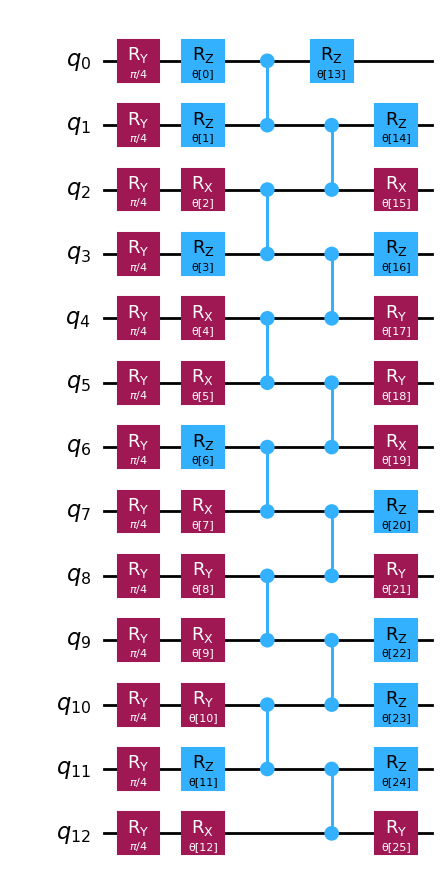

In [104]:
ansatz = RealAmplitudes(hamiltonian1.num_qubits, reps=1, entanglement='linear')
ansatz2 = PauliTwoDesign(hamiltonian1.num_qubits, reps=1)
ansatz2.decompose().draw('mpl')

In [105]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "parameters": [],
}

def cost_func_vqe(parameters, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])
    estimator_result = estimator_job.result()[0]

    cost = estimator_result.data.evs[0]
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = parameters
    cost_history_dict["cost_history"].append(cost)
    cost_history_dict["parameters"].append(parameters)
    return cost

In [106]:
from scipy.optimize import minimize
import numpy as np
from qiskit_aer import Aer
initial_params = np.random.uniform(low= -np.pi, high=np.pi, size=ansatz2.num_parameters)
result = minimize(cost_func_vqe, initial_params, args=(ansatz2, hamiltonian1, estimator), method="COBYLA",options={'maxiter': 50000, 'disp': True})
print(result)



 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 13951676273.54744
       x: [ 1.355e+00  3.138e+00 ... -2.130e+00  2.477e+00]
    nfev: 1111
   maxcv: 0.0
   Normal return from subroutine COBYLA


   NFVALS = 1111   F = 1.395168E+10    MAXCV = 0.000000E+00
   X = 1.354697E+00   3.137588E+00  -1.126089E-05   2.403842E+00  -9.623159E-05
       1.875694E-05   1.571289E+00  -3.141599E+00   5.497743E+00   3.141630E+00
      -3.926970E+00  -1.203498E-03  -1.131575E-05   1.888674E+00  -2.234964E+00
      -3.141548E+00  -1.316029E+00  -3.713277E+00  -3.563171E+00  -3.472646E+00
       1.876937E+00   3.141618E+00   1.375965E+00   3.118011E+00  -2.129619E+00
       2.477396E+00


$$
n = Cb
$$
Where $C$ is the conversion matrix, $b$ is the binary sequence generated from the opimized circuit and $n$ is the shares vector 

In [107]:
from qiskit.quantum_info import Statevector
from qiskit import transpile
# Assign optimal parameters to ansatz
final_circuit = ansatz2.assign_parameters(result.x)

final_circuit.measure_all()
simluator = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(final_circuit, simluator)
job_state = simluator.run(transpiled_circuit, shots=1000)

result = job_state.result()

counts = result.get_counts(final_circuit)

bitstring = max(counts, key=counts.get)
#bitstring = bitstring[::-1]  # reverse Qiskit 

print("Most likely bitstring:", bitstring)

# Convert to vector
b = np.array([int(bit) for bit in bitstring])
n = C @ b
print("\nOptimal number of shares to buy for each asset:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {int(n[i])} shares")

Most likely bitstring: 1011111110100

Optimal number of shares to buy for each asset:
AAPL: 13 shares
IBM: 15 shares
NFLX: 1 shares
TSLA: 1 shares


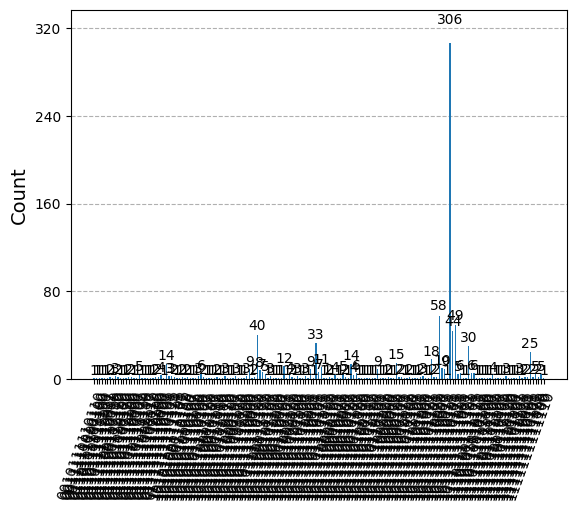

In [108]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [109]:

total_cost_scaled = P_double_prime.T @ b
print(f"\nTotal cost of the portfolio (scaled, normalized): {total_cost_scaled:.4f}") 
objective_function_penalty = -penalty*(P_double_prime.T @ b - 1)**2
print(f"Objective function value with penalty: {objective_function_penalty:.4f}")


Total cost of the portfolio (scaled, normalized): 3.8984
Objective function value with penalty: -84006051048.0265
